In [1]:
# The code was removed by DSX for sharing.

In [2]:
#Required Packages Section
if(!require(devtools)){
    install.packages("devtools")
    library(devtools)
}

Loading required package: devtools


In [3]:
# Install custom (IBM DSX GitHub) packages
# https://github.com/IBMDataScience/objectStoreR
install_github('IBMDataScience/objectStoreR')

Skipping install of 'objectStoreR' from a github remote, the SHA1 (d6a07c5b) has not changed since last install.
  Use `force = TRUE` to force installation


In [4]:
## Load objectStoreR into the session
library('objectStoreR')

In [5]:
# Using the package objectStoreR, invoke the "get" function to retrieve "sample.csv"
# from object storage and put into a data frame
sampleData <- objectStore.get(credentials_1)

No encoding supplied: defaulting to UTF-8.


In [6]:
# Verify dataframe
is.data.frame(sampleData)

[1] TRUE

In [7]:
# Output contents of data frame
sampleData

name age
1 fred 18 
2 sue  28 
3 alex 12

In [8]:
# Grab external data and put it into a dataframe
# Document the URL and timestamp for the download

fileUrl <- "https://spark-public.s3.amazonaws.com/dataanalysis/loansData.csv?accessType=DOWNLOAD"
download.file(fileUrl,destfile="./loansData.csv",mode="w")
loanDataRaw <- read.csv("./loansData.csv",as.is=TRUE)
# Mark the date of this download
dateDownloaded <- date()

In [9]:
# Self-document file source and download date
cat("File accessed from =>", fileUrl, "\n")
cat("File downloaded on =>" , dateDownloaded)

File accessed from => https://spark-public.s3.amazonaws.com/dataanalysis/loansData.csv?accessType=DOWNLOAD 
File downloaded on => Mon Mar 27 15:55:52 2017

In [10]:
# ------------------------------------
# --- DATA EXPLORATION BEGINS HERE ---
# ------------------------------------
# Quick look at the shape and size of "loanDataRaw"
# Use the "dim()" function to return the number of rows and columns
dim(loanDataRaw)

[1] 2500   14

In [11]:
# Quick look at shape and size of "loanDataRaw"
str(loanDataRaw)

# Additional R commands for investigation
# sapply(loanDataRaw[1,],class)
# summary(loandDataRaw)

'data.frame':	2500 obs. of  14 variables:
 $ Amount.Requested              : int  20000 19200 35000 10000 12000 6000 10000 33500 14675 7000 ...
 $ Amount.Funded.By.Investors    : num  20000 19200 35000 9975 12000 ...
 $ Interest.Rate                 : chr  "8.90%" "12.12%" "21.98%" "9.99%" ...
 $ Loan.Length                   : chr  "36 months" "36 months" "60 months" "36 months" ...
 $ Loan.Purpose                  : chr  "debt_consolidation" "debt_consolidation" "debt_consolidation" "debt_consolidation" ...
 $ Debt.To.Income.Ratio          : chr  "14.90%" "28.36%" "23.81%" "14.30%" ...
 $ State                         : chr  "SC" "TX" "CA" "KS" ...
 $ Home.Ownership                : chr  "MORTGAGE" "MORTGAGE" "MORTGAGE" "MORTGAGE" ...
 $ Monthly.Income                : num  6542 4583 11500 3833 3195 ...
 $ FICO.Range                    : chr  "735-739" "715-719" "690-694" "695-699" ...
 $ Open.CREDIT.Lines             : int  14 12 14 10 11 17 10 12 9 8 ...
 $ Revolving.CREDIT.Balance

In [12]:
# Write source data file to the object store.  This will prevent us from having to pull it
# down from the URL should we need it again.
write.csv(loanDataRaw, file ='loansData.csv')
status<- objectStore.put(credentials_1,'loansData.csv')
status

# ----------------------------------
# --- DATA EXPLORATION ENDS HERE ---
# ----------------------------------

[1] 201

In [13]:
# ----------------------------------
# --- DATA CLEANSING BEGINS HERE ---
# ----------------------------------

# Step 1
# Get rid of those pesky periods in the column heading.  This is not a requirement
# not will it necessarilly improve readability. However, I don't like looking at
# them and as such I am going to remove them.

cat("Column names before:","\n")
names(loanDataRaw)

names(loanDataRaw)<- gsub("\\.","", names(loanDataRaw))

# I need to fix a few other columns such that all columns conform to our chosen
# casing method of UpperCamelCase
colnames(loanDataRaw)[12] <- "RevolvingCreditBalance"
colnames(loanDataRaw)[11] <- "OpenCreditLines"
colnames(loanDataRaw)[13] <- "InquiriesLast6Months"

# Verify results
cat("Column names after:","\n")
names(loanDataRaw)

Column names before: 


[1] "Amount.Requested"               "Amount.Funded.By.Investors"    
 [3] "Interest.Rate"                  "Loan.Length"                   
 [5] "Loan.Purpose"                   "Debt.To.Income.Ratio"          
 [7] "State"                          "Home.Ownership"                
 [9] "Monthly.Income"                 "FICO.Range"                    
[11] "Open.CREDIT.Lines"              "Revolving.CREDIT.Balance"      
[13] "Inquiries.in.the.Last.6.Months" "Employment.Length"

Column names after: 


[1] "AmountRequested"         "AmountFundedByInvestors"
 [3] "InterestRate"            "LoanLength"             
 [5] "LoanPurpose"             "DebtToIncomeRatio"      
 [7] "State"                   "HomeOwnership"          
 [9] "MonthlyIncome"           "FICORange"              
[11] "OpenCreditLines"         "RevolvingCreditBalance" 
[13] "InquiriesLast6Months"    "EmploymentLength"

In [14]:
# Step 2
# Strip out '%' sign from InterestRate and DebtToIncomeRation
loanDataRaw$InterestRate <- gsub("%", "", as.character(loanDataRaw$InterestRate))
loanDataRaw$DebtToIncomeRatio <- gsub("%", "", as.character(loanDataRaw$DebtToIncomeRatio))
# Cast values to numeric
loanDataRaw$InterestRate <- as.numeric(loanDataRaw$InterestRate)
loanDataRaw$DebtToIncomeRatio <- as.numeric(loanDataRaw$DebtToIncomeRatio)

# Verify results
str(loanDataRaw)

'data.frame':	2500 obs. of  14 variables:
 $ AmountRequested        : int  20000 19200 35000 10000 12000 6000 10000 33500 14675 7000 ...
 $ AmountFundedByInvestors: num  20000 19200 35000 9975 12000 ...
 $ InterestRate           : num  8.9 12.12 21.98 9.99 11.71 ...
 $ LoanLength             : chr  "36 months" "36 months" "60 months" "36 months" ...
 $ LoanPurpose            : chr  "debt_consolidation" "debt_consolidation" "debt_consolidation" "debt_consolidation" ...
 $ DebtToIncomeRatio      : num  14.9 28.4 23.8 14.3 18.8 ...
 $ State                  : chr  "SC" "TX" "CA" "KS" ...
 $ HomeOwnership          : chr  "MORTGAGE" "MORTGAGE" "MORTGAGE" "MORTGAGE" ...
 $ MonthlyIncome          : num  6542 4583 11500 3833 3195 ...
 $ FICORange              : chr  "735-739" "715-719" "690-694" "695-699" ...
 $ OpenCreditLines        : int  14 12 14 10 11 17 10 12 9 8 ...
 $ RevolvingCreditBalance : int  14272 11140 21977 9346 14469 10391 15957 27874 7246 7612 ...
 $ InquiriesLast6Months   : 

In [15]:
# Step 3

# Break up FICORange into three new columns: FICOLow,FICOHigh,FICOAvg

# Split FICORange into FICOLow and FICOHigh
ficoSplitDat <- data.frame(do.call(rbind, strsplit(as.vector(loanDataRaw$FICORange), split = "-")))

# Assign column headings to new columns
names(ficoSplitDat)<- c("FICOLow", "FICOHigh")

# Convert FICOLow and FiCOHigh to data type numeric.
ficoSplitDat$FICOLow <- as.numeric(levels(ficoSplitDat$FICOLow))[ficoSplitDat$FICOLow]
ficoSplitDat$FICOHigh <- as.numeric(levels(ficoSplitDat$FICOHigh))[ficoSplitDat$FICOHigh]

# Append new columns to data frame
loanDataRaw <- cbind(loanDataRaw, ficoSplitDat)

# Calculate avg of FICOlow & FICOHigh then direct to new data.frame
ficoAvgDat <- data.frame(rowMeans(ficoSplitDat,na.rm=TRUE))

# Assign column heading to new column
names(ficoAvgDat)<- c("FICOAvg")

# Append new column to data frame
loanDataRaw <- cbind(loanDataRaw, ficoAvgDat)

# Verify results of the new columns
str(loanDataRaw[,c(10,15,16,17)])

'data.frame':	2500 obs. of  4 variables:
 $ FICORange: chr  "735-739" "715-719" "690-694" "695-699" ...
 $ FICOLow  : num  735 715 690 695 695 670 720 705 685 715 ...
 $ FICOHigh : num  739 719 694 699 699 674 724 709 689 719 ...
 $ FICOAvg  : num  737 717 692 697 697 672 722 707 687 717 ...


In [16]:
# Step 4

# Are there any rows with null values in any of the columns
nullRowCount <- nrow(loanDataRaw[!complete.cases(loanDataRaw),])
cat(nullRowCount,"rows out of", nrow(loanDataRaw), "have 1 or more fields with null values.","\n\n")


# There are only two and for demonstration purposes I will remove them
cat("Row counter before =>", nrow(loanDataRaw), "\n")
loanDataRaw <- na.omit(loanDataRaw)
cat("Row counter after =>", nrow(loanDataRaw), "\n")


2 rows out of 2500 have 1 or more fields with null values. 

Row counter before => 2500 
Row counter after => 2498 


In [17]:
# Step 5

# When the number of unique values (strings) within a column is small it can make sense to convert
# those string to numerical values.
# There are many reasons you may want to do this, e.g. Statistical modeling, and functions
# that just recognize numerics like the Pearson Correlation "cor()" funciton.

# LOAN PURPOSE
# Covert character strings to factors (levels)
loanDataRaw$LoanPurpose <- factor(loanDataRaw$LoanPurpose)
# Map strings to numerical represenation:
levels(loanDataRaw$LoanPurpose) <- list(
    "0" = c("debt_consolidation"),
    "1" = c("credit_card"),
    "2" = c("other"),
    "3" = c("moving"),
    "4" = c("car"),
    "5" = c("vacation"),
    "6" = c("home_improvement"),
    "7" = c("house"),
    "8" = c("major_purchase"),
    "9" = c("educational"),
    "10" = c("medical"),
    "11" = c("wedding"),
    "12" = c("small_business"),
    "13" = c("renewable_energy")
)
# Cast string to numeric
loanDataRaw$LoanPurpose <- as.numeric(as.character(loanDataRaw$LoanPurpose))


# EMPLOYMENT LENGTH
# Covert character strings to factors (levels)
loanDataRaw$EmploymentLength <- factor(loanDataRaw$EmploymentLength)
# Map strings to numerical represenation:
levels(loanDataRaw$EmploymentLength) <- list(
    "0" = c("< 1 year"),
    "1" = c("1 year"),
    "2" = c("2 years"),
    "3" = c("3 years"),
    "4" = c("4 years"),
    "5" = c("5 years"),
    "6" = c("6 years"),
    "7" = c("7 years"),
    "8" = c("8 years"),
    "9" = c("9 years"),
    "10" = c("10+ years"),
    "11" = c("n/a")
)
# Cast string to numeric
loanDataRaw$EmploymentLength <- as.numeric(as.character(loanDataRaw$EmploymentLength))


# HOME OWNERSHIP
# Covert character strings to factors (levels)
loanDataRaw$HomeOwnership <- factor(loanDataRaw$HomeOwnership)
# Map strings to numerical represenation:
levels(loanDataRaw$HomeOwnership) <- list(
    "0" = c("MORTGAGE"),
    "1" = c("RENT"),
    "2" = c("OWN"),
    "3" = c("OTHER"),
    "4" = c("NONE")
)
# Cast string to numeric
loanDataRaw$HomeOwnership <- as.numeric(as.character(loanDataRaw$HomeOwnership))

# LOAN LENGTH
# Covert character strings to factors (levels)
loanDataRaw$LoanLength <- factor(loanDataRaw$LoanLength)
# Change levels:
levels(loanDataRaw$LoanLength) <- list(
    "36" = c("36 months"),
    "60" = c("60 months")
)
# Cast string to numeric
loanDataRaw$LoanLength <- as.numeric(as.character(loanDataRaw$LoanLength))

In [18]:
# Quick check of the data
str(loanDataRaw)

'data.frame':	2498 obs. of  17 variables:
 $ AmountRequested        : int  20000 19200 35000 10000 12000 6000 10000 33500 14675 7000 ...
 $ AmountFundedByInvestors: num  20000 19200 35000 9975 12000 ...
 $ InterestRate           : num  8.9 12.12 21.98 9.99 11.71 ...
 $ LoanLength             : num  36 36 60 36 36 36 36 60 36 36 ...
 $ LoanPurpose            : num  0 0 0 0 1 2 0 1 1 1 ...
 $ DebtToIncomeRatio      : num  14.9 28.4 23.8 14.3 18.8 ...
 $ State                  : chr  "SC" "TX" "CA" "KS" ...
 $ HomeOwnership          : num  0 0 0 0 1 2 1 0 1 1 ...
 $ MonthlyIncome          : num  6542 4583 11500 3833 3195 ...
 $ FICORange              : chr  "735-739" "715-719" "690-694" "695-699" ...
 $ OpenCreditLines        : int  14 12 14 10 11 17 10 12 9 8 ...
 $ RevolvingCreditBalance : int  14272 11140 21977 9346 14469 10391 15957 27874 7246 7612 ...
 $ InquiriesLast6Months   : int  2 1 1 0 0 2 0 0 1 0 ...
 $ EmploymentLength       : num  0 2 2 5 9 3 10 10 8 3 ...
 $ FICOLow        

In [19]:
# Write cleansed data to object data store
loanDataFinal <- as.data.frame(loanDataRaw)
write.csv(loanDataRaw, file ='loanDataPrepped.csv')

# Mark the date of this operation
dateAnalyzed <- date()
dateAnalyzed

status<- objectStore.put(credentials_1,'loanDataPrepped.csv')
status

[1] "Mon Mar 27 15:55:53 2017"

[1] 201

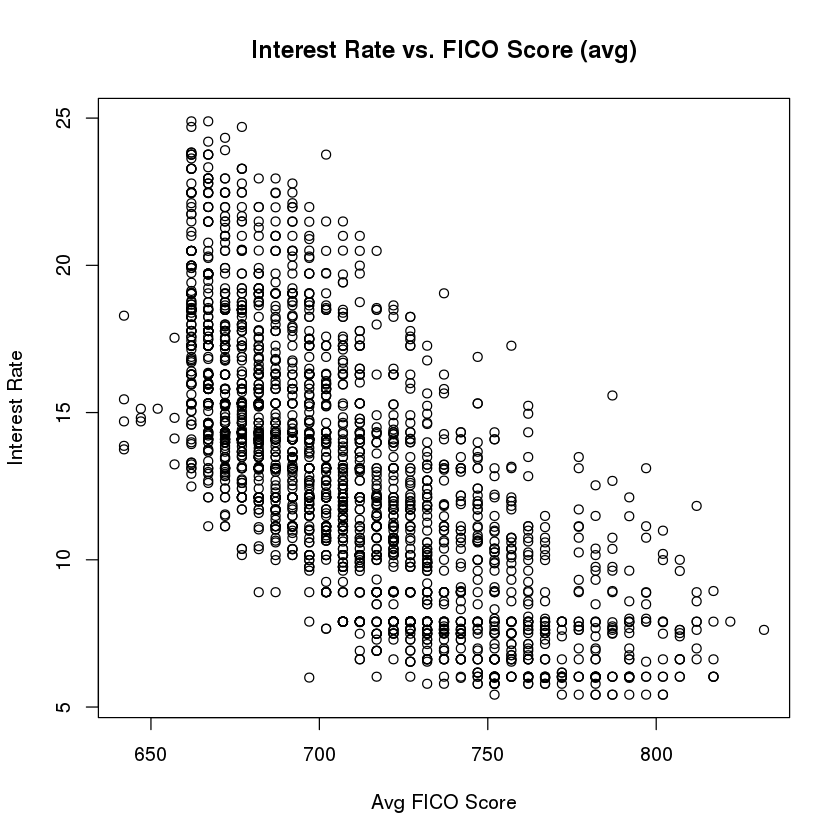

In [20]:
# ---------------------------------
# --- DATA ANALYSIS BEGINS HERE ---
# ---------------------------------

# Exploratory Graphs
plot(loanDataFinal$InterestRate ~ loanDataFinal$FICOAvg, 
     data=loanDataFinal, 
     main="Interest Rate vs. FICO Score (avg)",
     xlab="Avg FICO Score",
     ylab="Interest Rate")

In [21]:
# Check for corrleations

cor(loanDataFinal[c(2,3,4,6,9,12,17)], use="all.obs", method="pearson")
# Output indicates:
# a strong negative correlation between Interest Rate and FICO Avg: -0 .709
# a moderate positive correlation between Interest Rate and AmountFunded: 0.337
# a moderate positive correlation between Interest Rate and LoanLength: 0.423

AmountFundedByInvestors InterestRate LoanLength
AmountFundedByInvestors 1.00000000               0.33683030  0.40621845
InterestRate            0.33683030               1.00000000  0.42350577
LoanLength              0.40621845               0.42350577  1.00000000
DebtToIncomeRatio       0.09367885               0.17220278  0.02499105
MonthlyIncome           0.37437674               0.01292112  0.07454463
RevolvingCreditBalance  0.26189160               0.06110888  0.05543606
FICOAvg                 0.07428400              -0.70921624  0.01270322
                        DebtToIncomeRatio MonthlyIncome RevolvingCreditBalance
AmountFundedByInvestors  0.09367885        0.37437674   0.261891599           
InterestRate             0.17220278        0.01292112   0.061108876           
LoanLength               0.02499105        0.07454463   0.055436058           
DebtToIncomeRatio        1.00000000       -0.16234470   0.189221189           
MonthlyIncome           -0.16234470        1.00000000   0.359684410           
RevolvingCreditBalance   0.18922119        0.35968441   1.000000000           
FICOAvg                 -0.21696295        0.12271376   0.002917455           
                        FICOAvg     
AmountFundedByInvestors  0.074283999
InterestRate            -0.709216240
LoanLength               0.012703216
DebtToIncomeRatio       -0.216962950
MonthlyIncome            0.122713756
RevolvingCreditBalance   0.002917455
FICOAvg                  1.000000000

In [22]:
# ----------------------------------------------------
# -- Linear Analysis (Interest Rate v. FICO Avg Score)
# ----------------------------------------------------
#Linear Analysis (Interest Rate vs. FICO Avg Score)
par(mfrow=c(1,1))
lm1<- lm(loanDataFinal$InterestRate ~ loanDataFinal$FICOAvg)
lm1
summary(lm1)


Call:
lm(formula = loanDataFinal$InterestRate ~ loanDataFinal$FICOAvg)

Coefficients:
          (Intercept)  loanDataFinal$FICOAvg  
             73.00811               -0.08467  



Call:
lm(formula = loanDataFinal$InterestRate ~ loanDataFinal$FICOAvg)

Residuals:
    Min      1Q  Median      3Q     Max 
-7.9898 -2.1363 -0.4565  1.8351 10.1935 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)           73.008107   1.194023   61.15   <2e-16 ***
loanDataFinal$FICOAvg -0.084675   0.001685  -50.26   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.946 on 2496 degrees of freedom
Multiple R-squared:  0.503,	Adjusted R-squared:  0.5028 
F-statistic:  2526 on 1 and 2496 DF,  p-value: < 2.2e-16


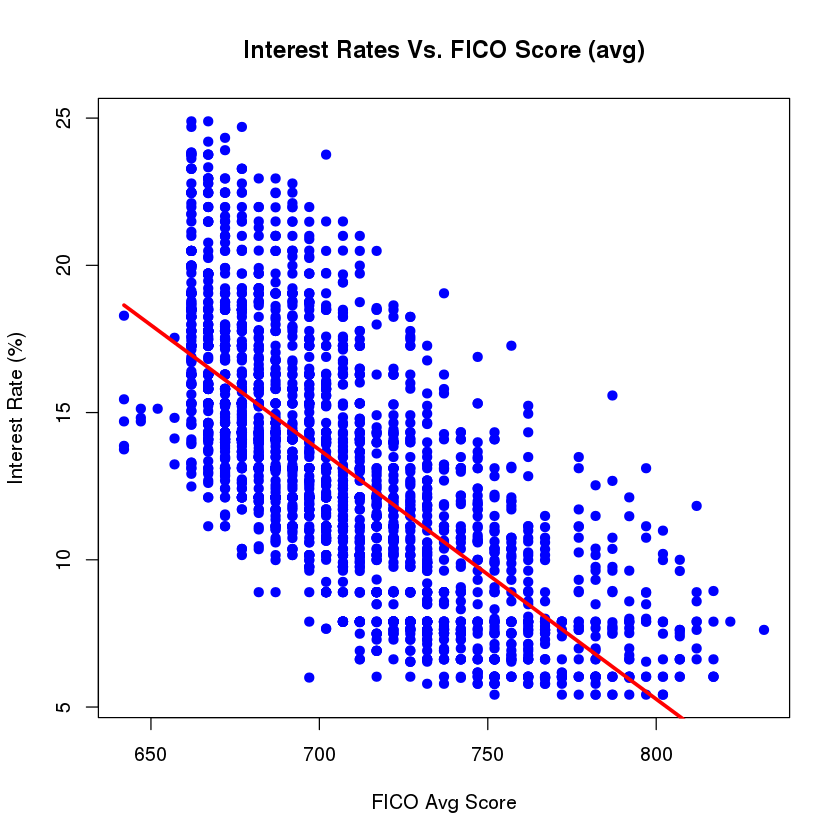

In [23]:
#export Graph (Interest Rate vs. FICO AVg Score)
plot(loanDataFinal$InterestRate ~ loanDataFinal$FICOAvg, pch=19, col='blue',
     xlab="FICO Avg Score",ylab="Interest Rate (%)", main="Interest Rates Vs. FICO Score (avg)")
lines(loanDataFinal$FICOAvg, lm1$fitted, col='red', lwd=3)